# Problem:

How should CS Division staff their agents so that the planned service level is maintained while total labor costs are minimized?

# Modelling approach:

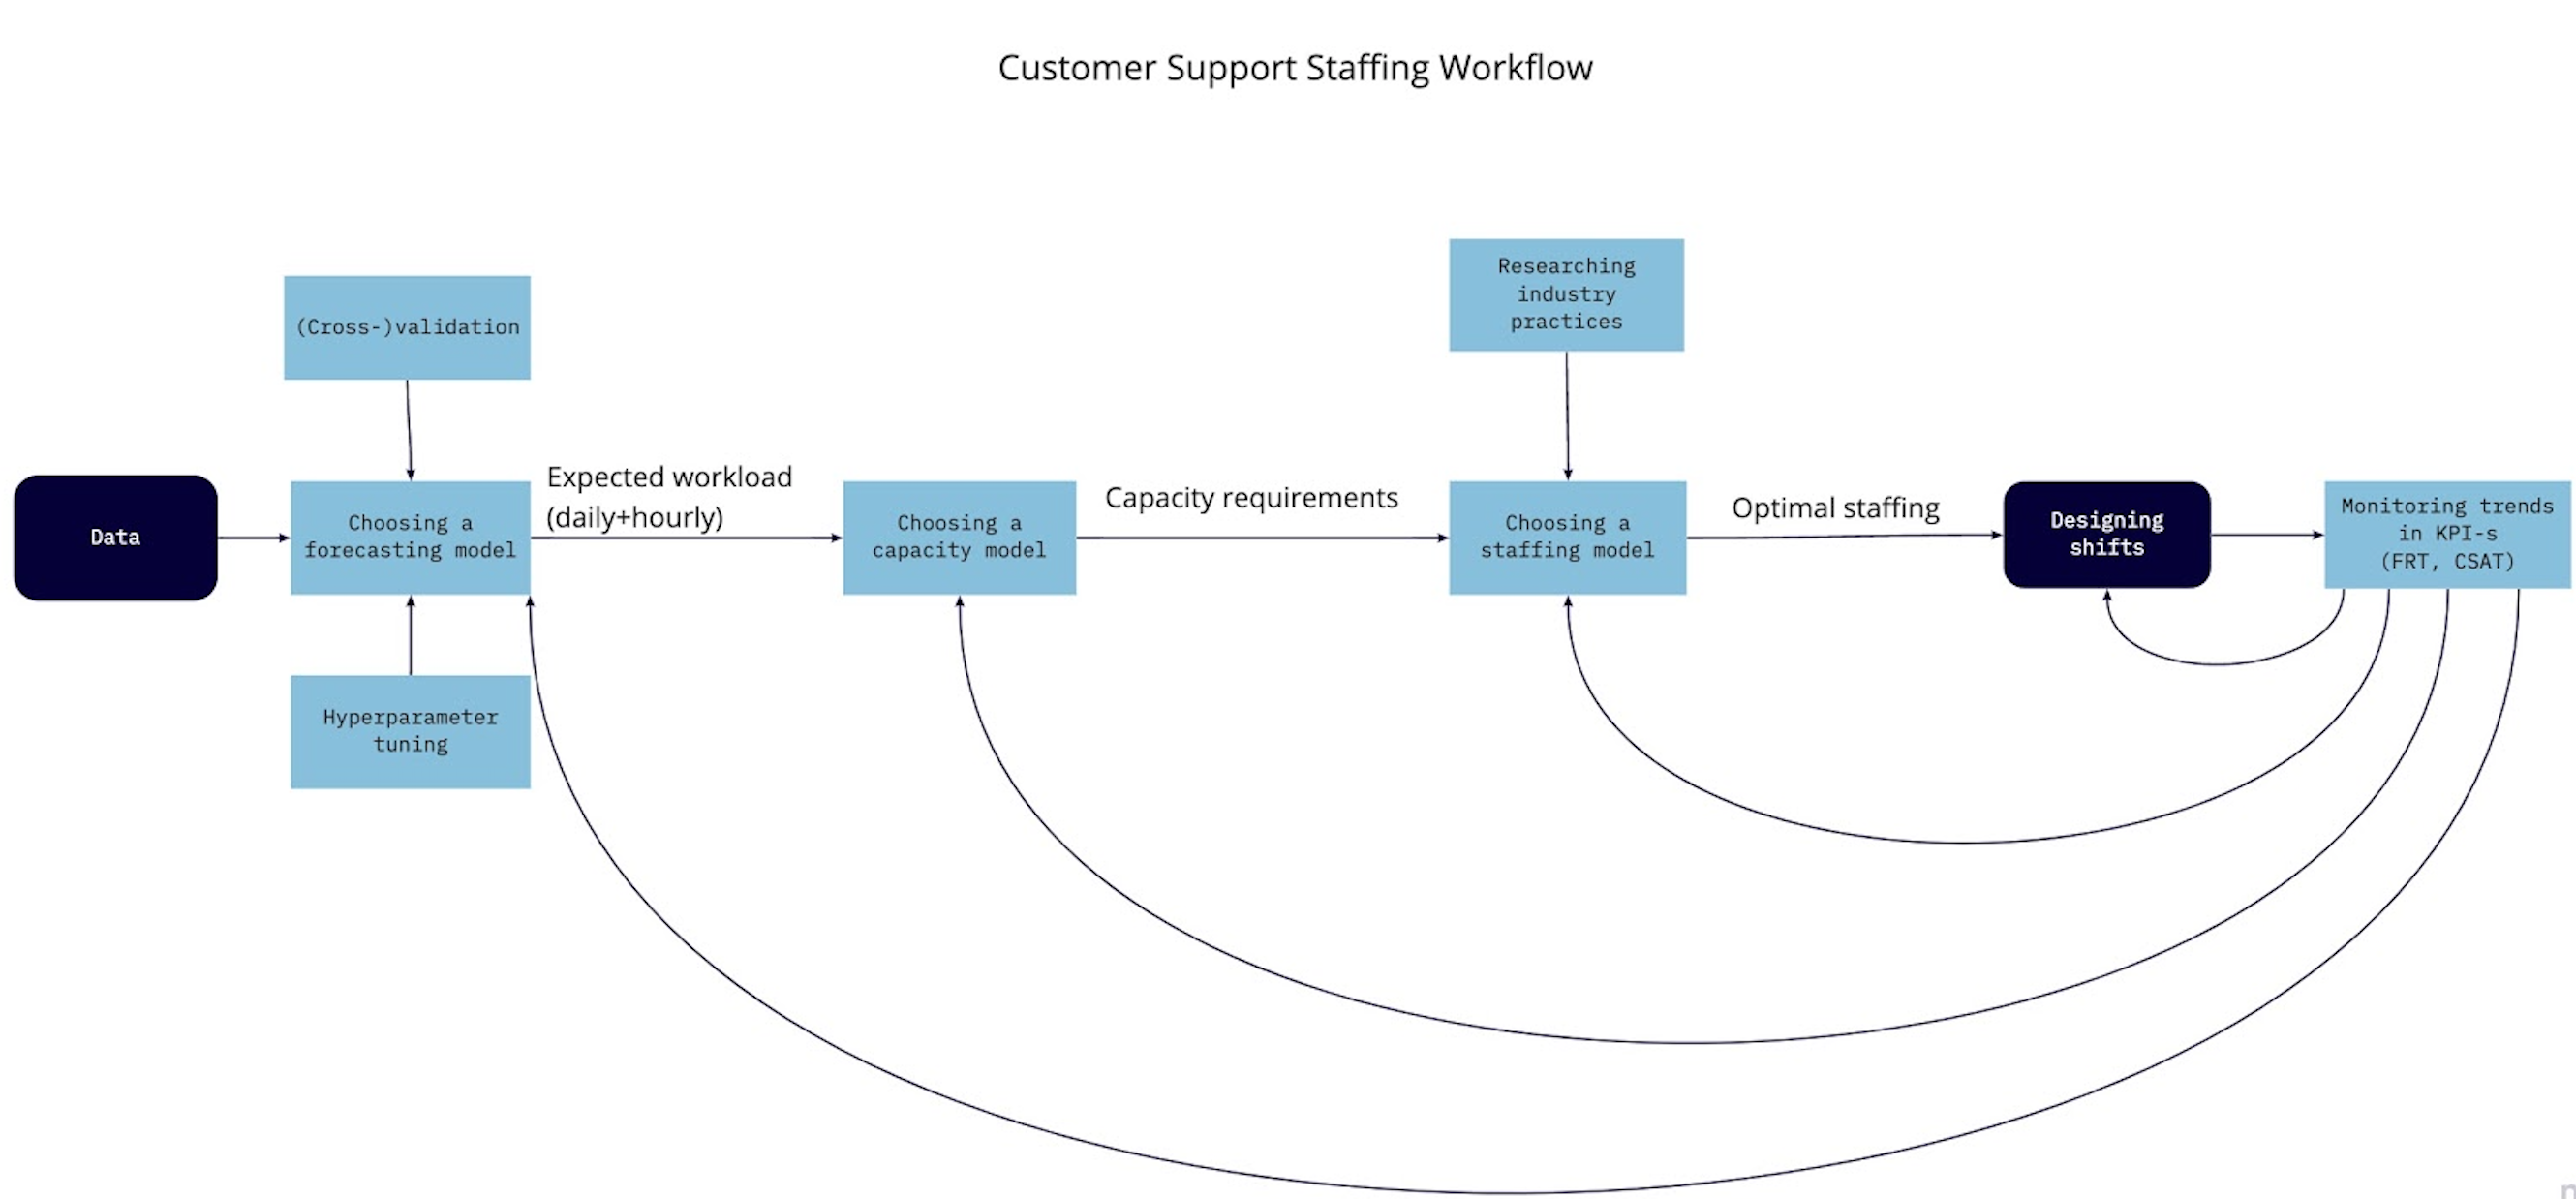

### Framing the problem:

Before proceeding to Exploratory Data Analysis (EDA), it is important to understand how the company expects to use and benefit from this model. This will help me determine how to frame the problem, what algorithms to select and how to evaluate the performance of each one.

I can categorize my **Machine Learning system** as:
 - Supervised learning task: I am given some labeled data that I can split into training and testing sets (in plain English - I already have comprehensive data on past complaint tickets and I can observe how many tickets were received in a given space of time (every month, week, day, hour or even minute)).
 - Regression task: my algorithms is expected to predict the number of complaint tickets received in a given period of time (24 hours in this particular case).
 - Plain batch learning: since there is no continuous flow of data coming into my system, there is no particular need to adjust to changing data rapidly. In addition, the data is small enough to fit in memory, so plain batch learning should suffice.

### Understanding the data:

Before proceeding to choosing the forecasting model, let's first understand what kind of data we have. I export the raw data containing information on each individual ticket received between November 1, 2019 and January 30, 2020. However, since I am tasked with generating the daily workload measured in the number of incoming tickets, I can transform the raw data into a kind of data that has data points sequenced or indexed in a time-based order with, for instance , the 24-hour interval between observations. This is also known as **time-series** data. Theoretically, the analysis can be extended to hourly intervals too so that I can attempt to predict how many tickets will be received on any given hour within the next month. Using time-series forecasting will enable us to create monthly, quaterly or even annual staffing plans to help us answer the demand.

Surely, time-series forecasting is difficult due to its inherent uncertainty, especially when the forecasting horizon is longer than a week. For example, it's not immediately clear whether a given time-series can be categorized as stochastic, deterministic, chaotic or any combination of those. Still, with sufficient amount of historical data, one can attempt to generate reasonably precise forecasts that will help as maintain good service level while not overhiring and, as a result, unnecessarily increasing labor expenditures. 

As a general rule of thumb, to ensure reasonably accurate forecasts my time series should **ideally** meet the following characteristics:

 - Hourly, daily or weekly observation within at least a few months (minimum 1 month), but 1 year of historical data is much preferred.

 - Data should be strongly seasonal - there should be regularly spaced patterns over the course of a week or between seasons of a year.

 - Important events (e.g. new product feature launches) or holidays that occur must be noted

 - A reasonable number of missing or outlier (inlier) data

 - Historical **trend** changes

In [1]:
#Initializing packages and importing data
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
os.chdir("/Users/aida.aman/Desktop/AERC")
import statsmodels.tsa.seasonal as season
import warnings
warnings.filterwarnings("ignore")
import pprint
tickets = pd.read_csv("/Users/aida.aman/Desktop/Bolt/tickets.csv")

## Data pre-processing:

This is what my data looks like before it is prepared for analysis:

In [2]:
pp = pprint.PrettyPrinter(indent=10, width=80, compact=True)
pp.pprint(tickets)

          ticket_created_at ticket_first_responded_at ticket_last_solved_at  \
0       2019-11-04 11:09:09       2019-11-04 11:20:44   2019-11-04 11:20:44   
1       2019-11-05 02:11:44       2019-11-05 02:20:46   2019-11-05 02:20:46   
2       2019-11-03 17:42:28       2019-11-03 18:14:03   2019-11-07 11:39:07   
3       2019-11-06 12:23:54       2019-11-06 12:28:10   2019-11-06 13:38:16   
4       2019-11-04 16:08:27       2019-11-04 16:35:56   2019-11-07 08:07:39   
...                     ...                       ...                   ...   
126426  2020-01-28 11:55:29       2020-01-29 00:37:29   2020-01-29 00:37:29   
126427  2020-01-29 23:30:38       2020-01-30 02:05:31   2020-01-30 02:05:31   
126428  2020-01-29 22:52:45       2020-01-30 03:32:45   2020-01-30 03:32:45   
126429  2019-12-08 15:28:07       2019-12-08 15:28:07   2019-12-08 15:28:07   
126430  2020-01-26 01:36:12       2020-01-26 01:36:12   2020-01-26 01:36:12   

                         id  first_response_time  t

To start off, I will exclude all duplicate and auto-solved tickets by dropping tickets with identical **id-s** as well as the ones that did not merit a response by an agent (i.e. where the value for first_response_time is missing).

In [3]:
tickets = tickets.dropna(how ='all', subset=['first_response_time'])
tickets = tickets.rename(columns = {'ticket_created_at':'date'})
tickets['date']=pd.to_datetime(tickets['date'])
tickets['is_incoming']=tickets['is_incoming'].replace('t', 1)
tickets['is_incoming']=tickets['is_incoming'].replace('f', 0)
tickets = tickets.drop_duplicates(subset = 'id')
tickets = tickets.drop(columns=['id', 'ticket_first_responded_at', 'ticket_last_solved_at'])
pp.pprint(tickets)

                      date  first_response_time  total_resolution_time  \
0      2019-11-04 11:09:09             0.193308               0.193308   
1      2019-11-05 02:11:44             0.150810               0.150810   
2      2019-11-03 17:42:28             0.526437              89.944431   
3      2019-11-06 12:23:54             0.070972               1.239324   
4      2019-11-04 16:08:27             0.458291              63.986847   
...                    ...                  ...                    ...   
126426 2020-01-28 11:55:29            12.699912              12.699912   
126427 2020-01-29 23:30:38             2.581205               2.581205   
126428 2020-01-29 22:52:45             4.666505               4.666505   
126429 2019-12-08 15:28:07             0.000000               0.000000   
126430 2020-01-26 01:36:12             0.000000               0.000000   

           user_type  is_incoming  
0              rider            1  
1             driver            1  
2  

Now, I will create a time-series of **incoming** tickets by grouping the observations from the same day.

In [4]:
tickets = tickets.set_index(pd.DatetimeIndex(tickets['date']))
tickets_daily = tickets['is_incoming'].resample('D').sum()
tickets_daily = tickets_daily.to_frame()
tickets_daily = tickets_daily.rename(columns={"is_incoming": "y"})
pp.pprint(tickets_daily)

               y
date            
2019-11-01  1323
2019-11-02   905
2019-11-03   952
2019-11-04  1149
2019-11-05   959
...          ...
2020-01-26   913
2020-01-27  1097
2020-01-28  1046
2020-01-29   976
2020-01-30   936

[91 rows x 1 columns]


I can also create a similar daily time series of average FRT for further insights later on.

In [5]:
FRT_daily = tickets['first_response_time'].resample('D').mean()
FRT_daily = FRT_daily.to_frame()
FRT_daily = FRT_daily.rename(columns={"first_response_time": "FRT"})
pp.pprint(FRT_daily)

                  FRT
date                 
2019-11-01   3.478356
2019-11-02   3.509577
2019-11-03   2.608150
2019-11-04   4.674779
2019-11-05   3.747375
...               ...
2020-01-26  12.230360
2020-01-27  27.180092
2020-01-28  13.219366
2020-01-29   9.560157
2020-01-30   9.368856

[91 rows x 1 columns]


## Exploration:

Any time series has 4 components:
    
1. **Trend** - an increase or decrease in values. It can be linear or nonlinear (e.g. logistic)
2. **Seasonality** - regular and predictable movement after a fixed period of time
3. **Cycles** - regular or periodic fluctuation in the data
4. **Noise** - whatever is left after the trend-cycle and the seasonal components have been removed

First, I will plot my time series for visual inspection.

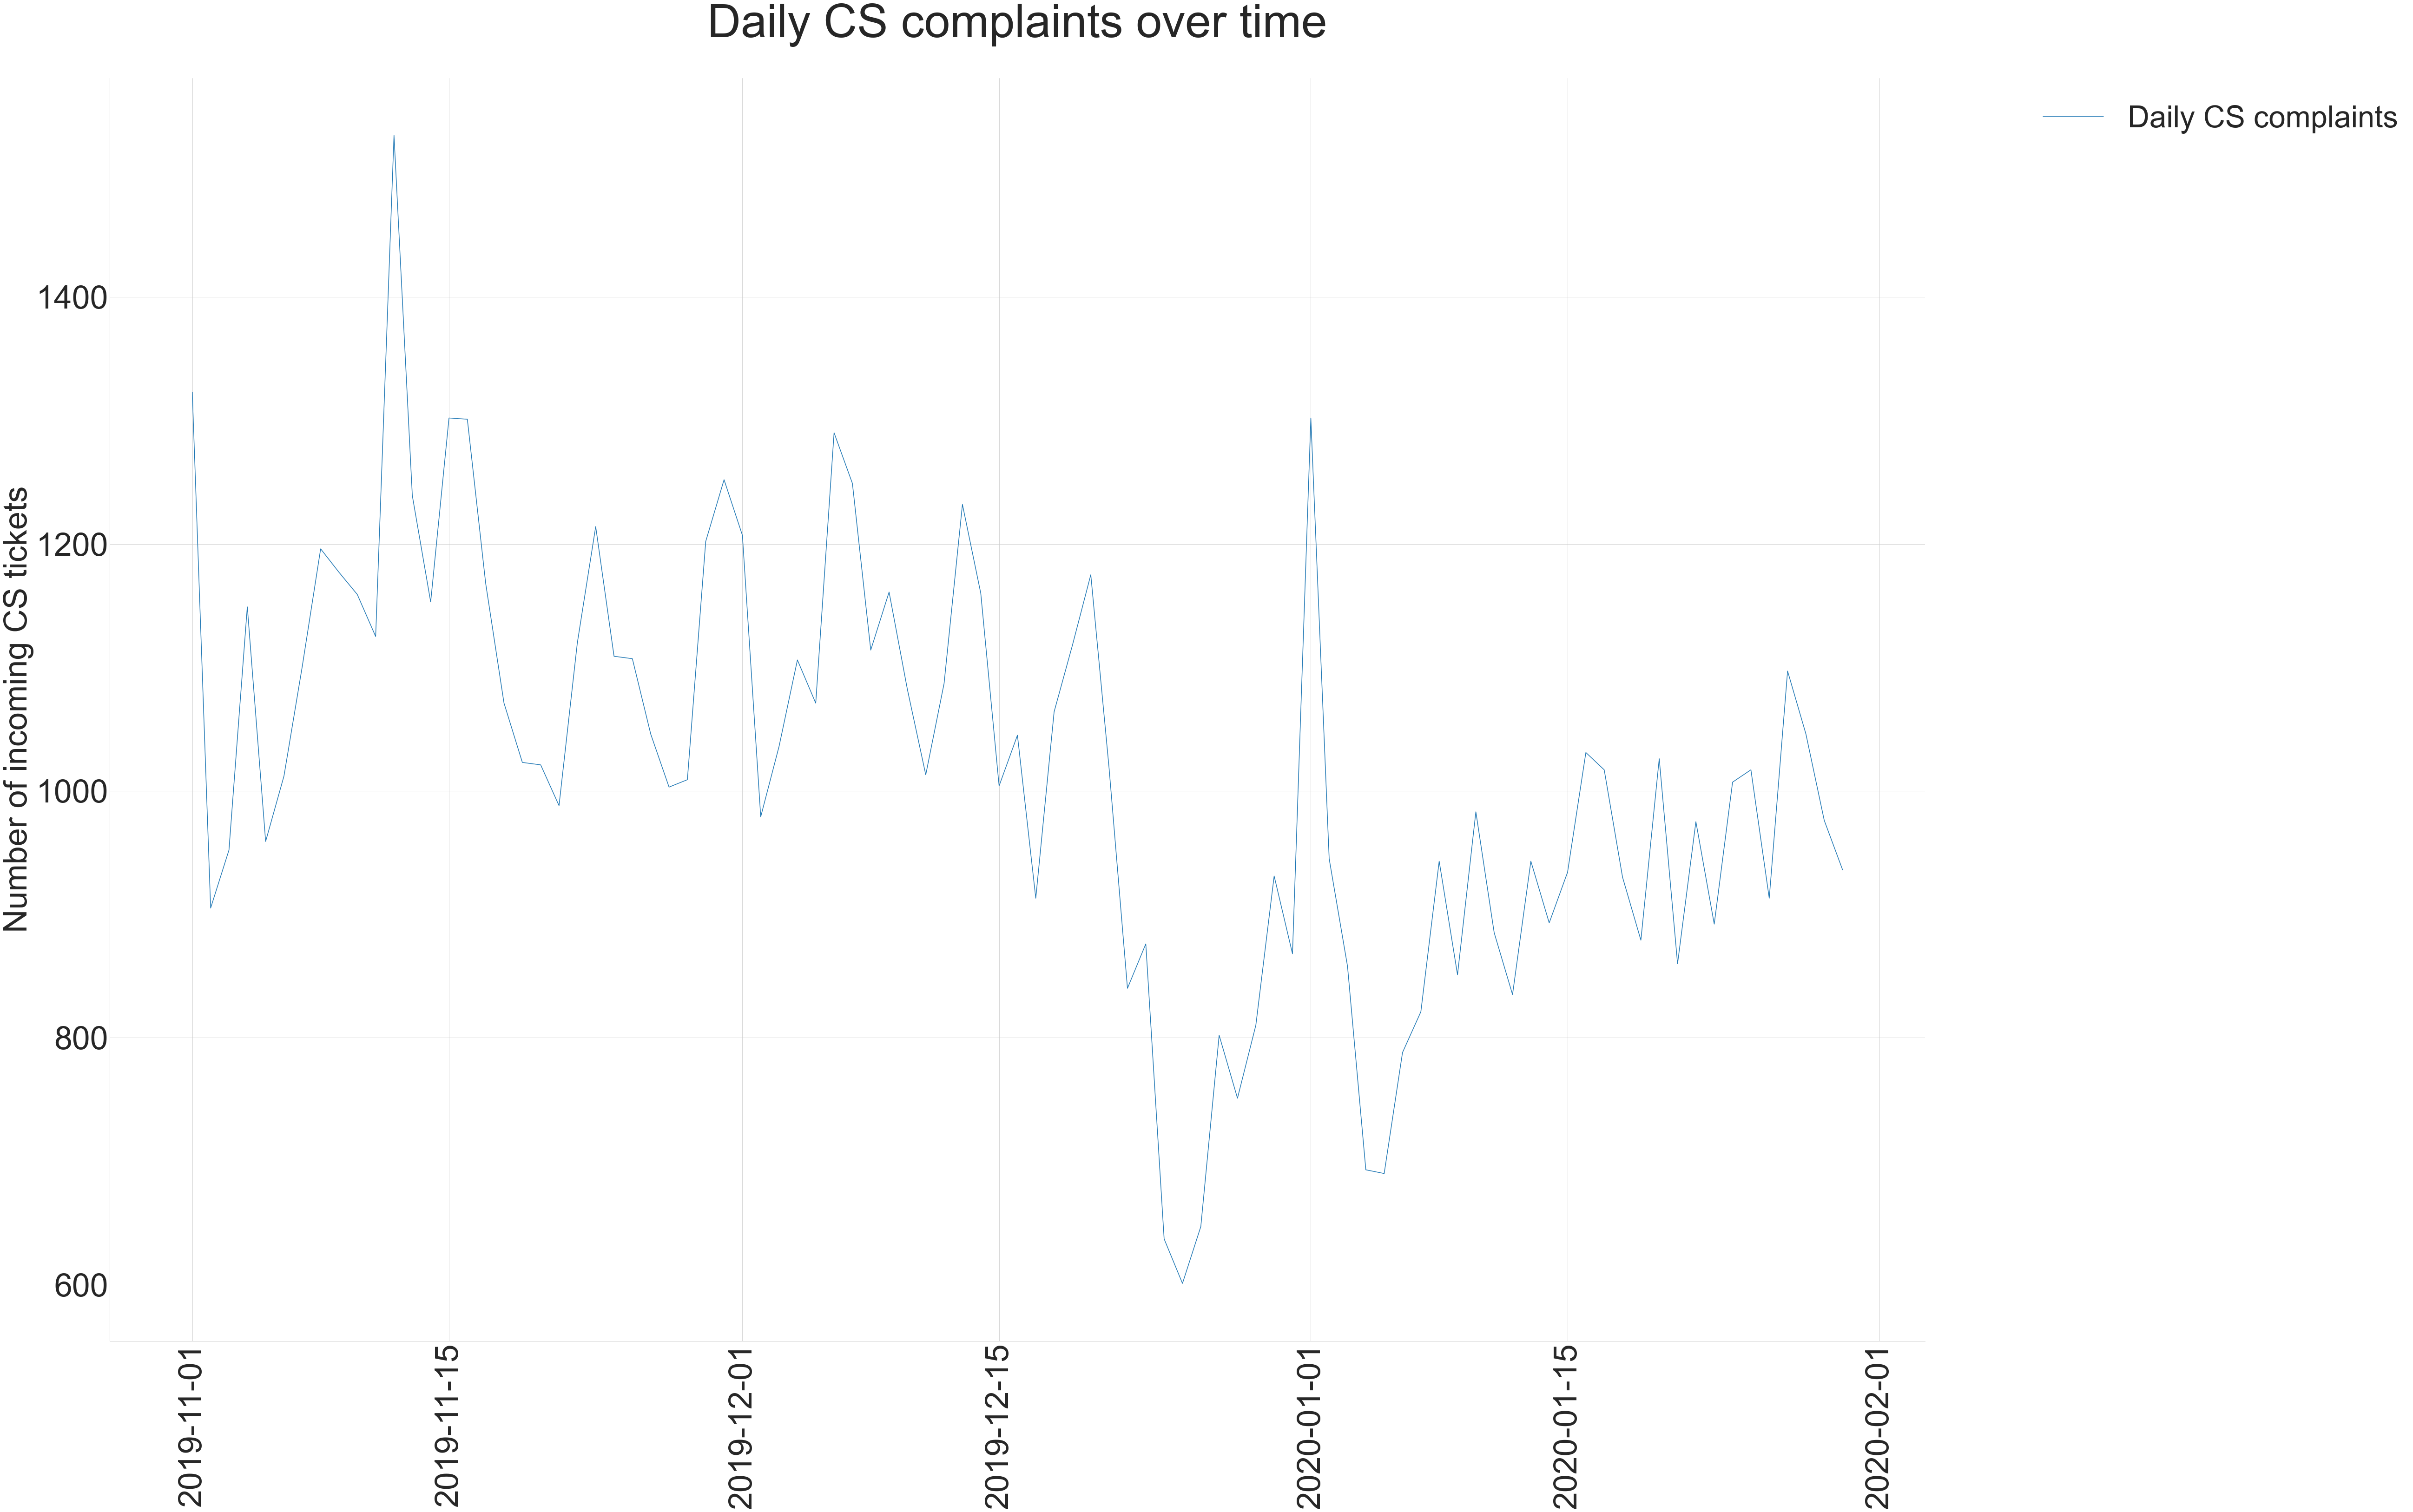

In [6]:
plt.rcParams["figure.figsize"] = (70,50)
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.plot( tickets_daily["y"], label="Daily CS complaints")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5,prop={'size':65})
plt.title('Daily CS complaints over time', fontsize=100, y=1.03)
plt.ylabel('Number of incoming CS tickets', fontsize=70)
label_size = 70
degrees = 90
plt.xticks(fontsize = label_size, rotation=degrees)
plt.yticks(fontsize = label_size)
plt.show()

We can see that the time series is stationary, i.e. it fluctuates around what seems to be a constant average, or **baseline**. That also means that there is no clear upward or downward trend. This is good news for us as it looks like I will be able to apply any standard time-series forecasting model without further transformation of the data. The time series also seems to display seasonality but I will take a closer look at that later by explicitly decomposing the time series into components.

### Decomposing the time series:

In [7]:
def decompose_time_series(series):
    result = season.seasonal_decompose(series, model='additive')
    result.plot()
    plt.show()

The uppermost graph is basically a plot of the series itself. A casual inspection reveals that the series is mostly fluctuating around the mean with one pronounced spike and doesn't exhibit a clear upward or downward trend. We can also see that the series is **strongly seasonal**, with regularly spaced 'highs' and 'lows'.

If we take a closer look at the seasonal component of the time-series, we can validate a trend that logically makes sense: there is a spike in incoming tickets each Friday and Saturday, which is predictable due to the rise in the number of completed rides and people's tendency to consumer alcohol towards the weekend, while the drivers may also want to settle their earnings-related queries before the weekend. An important note is that I can already choose to use the "additive" seasonality mode because we can be fairly certain that the seasonal variation is relatively constant over time by merely looking at the seasonal component illustrated in the third plot below.

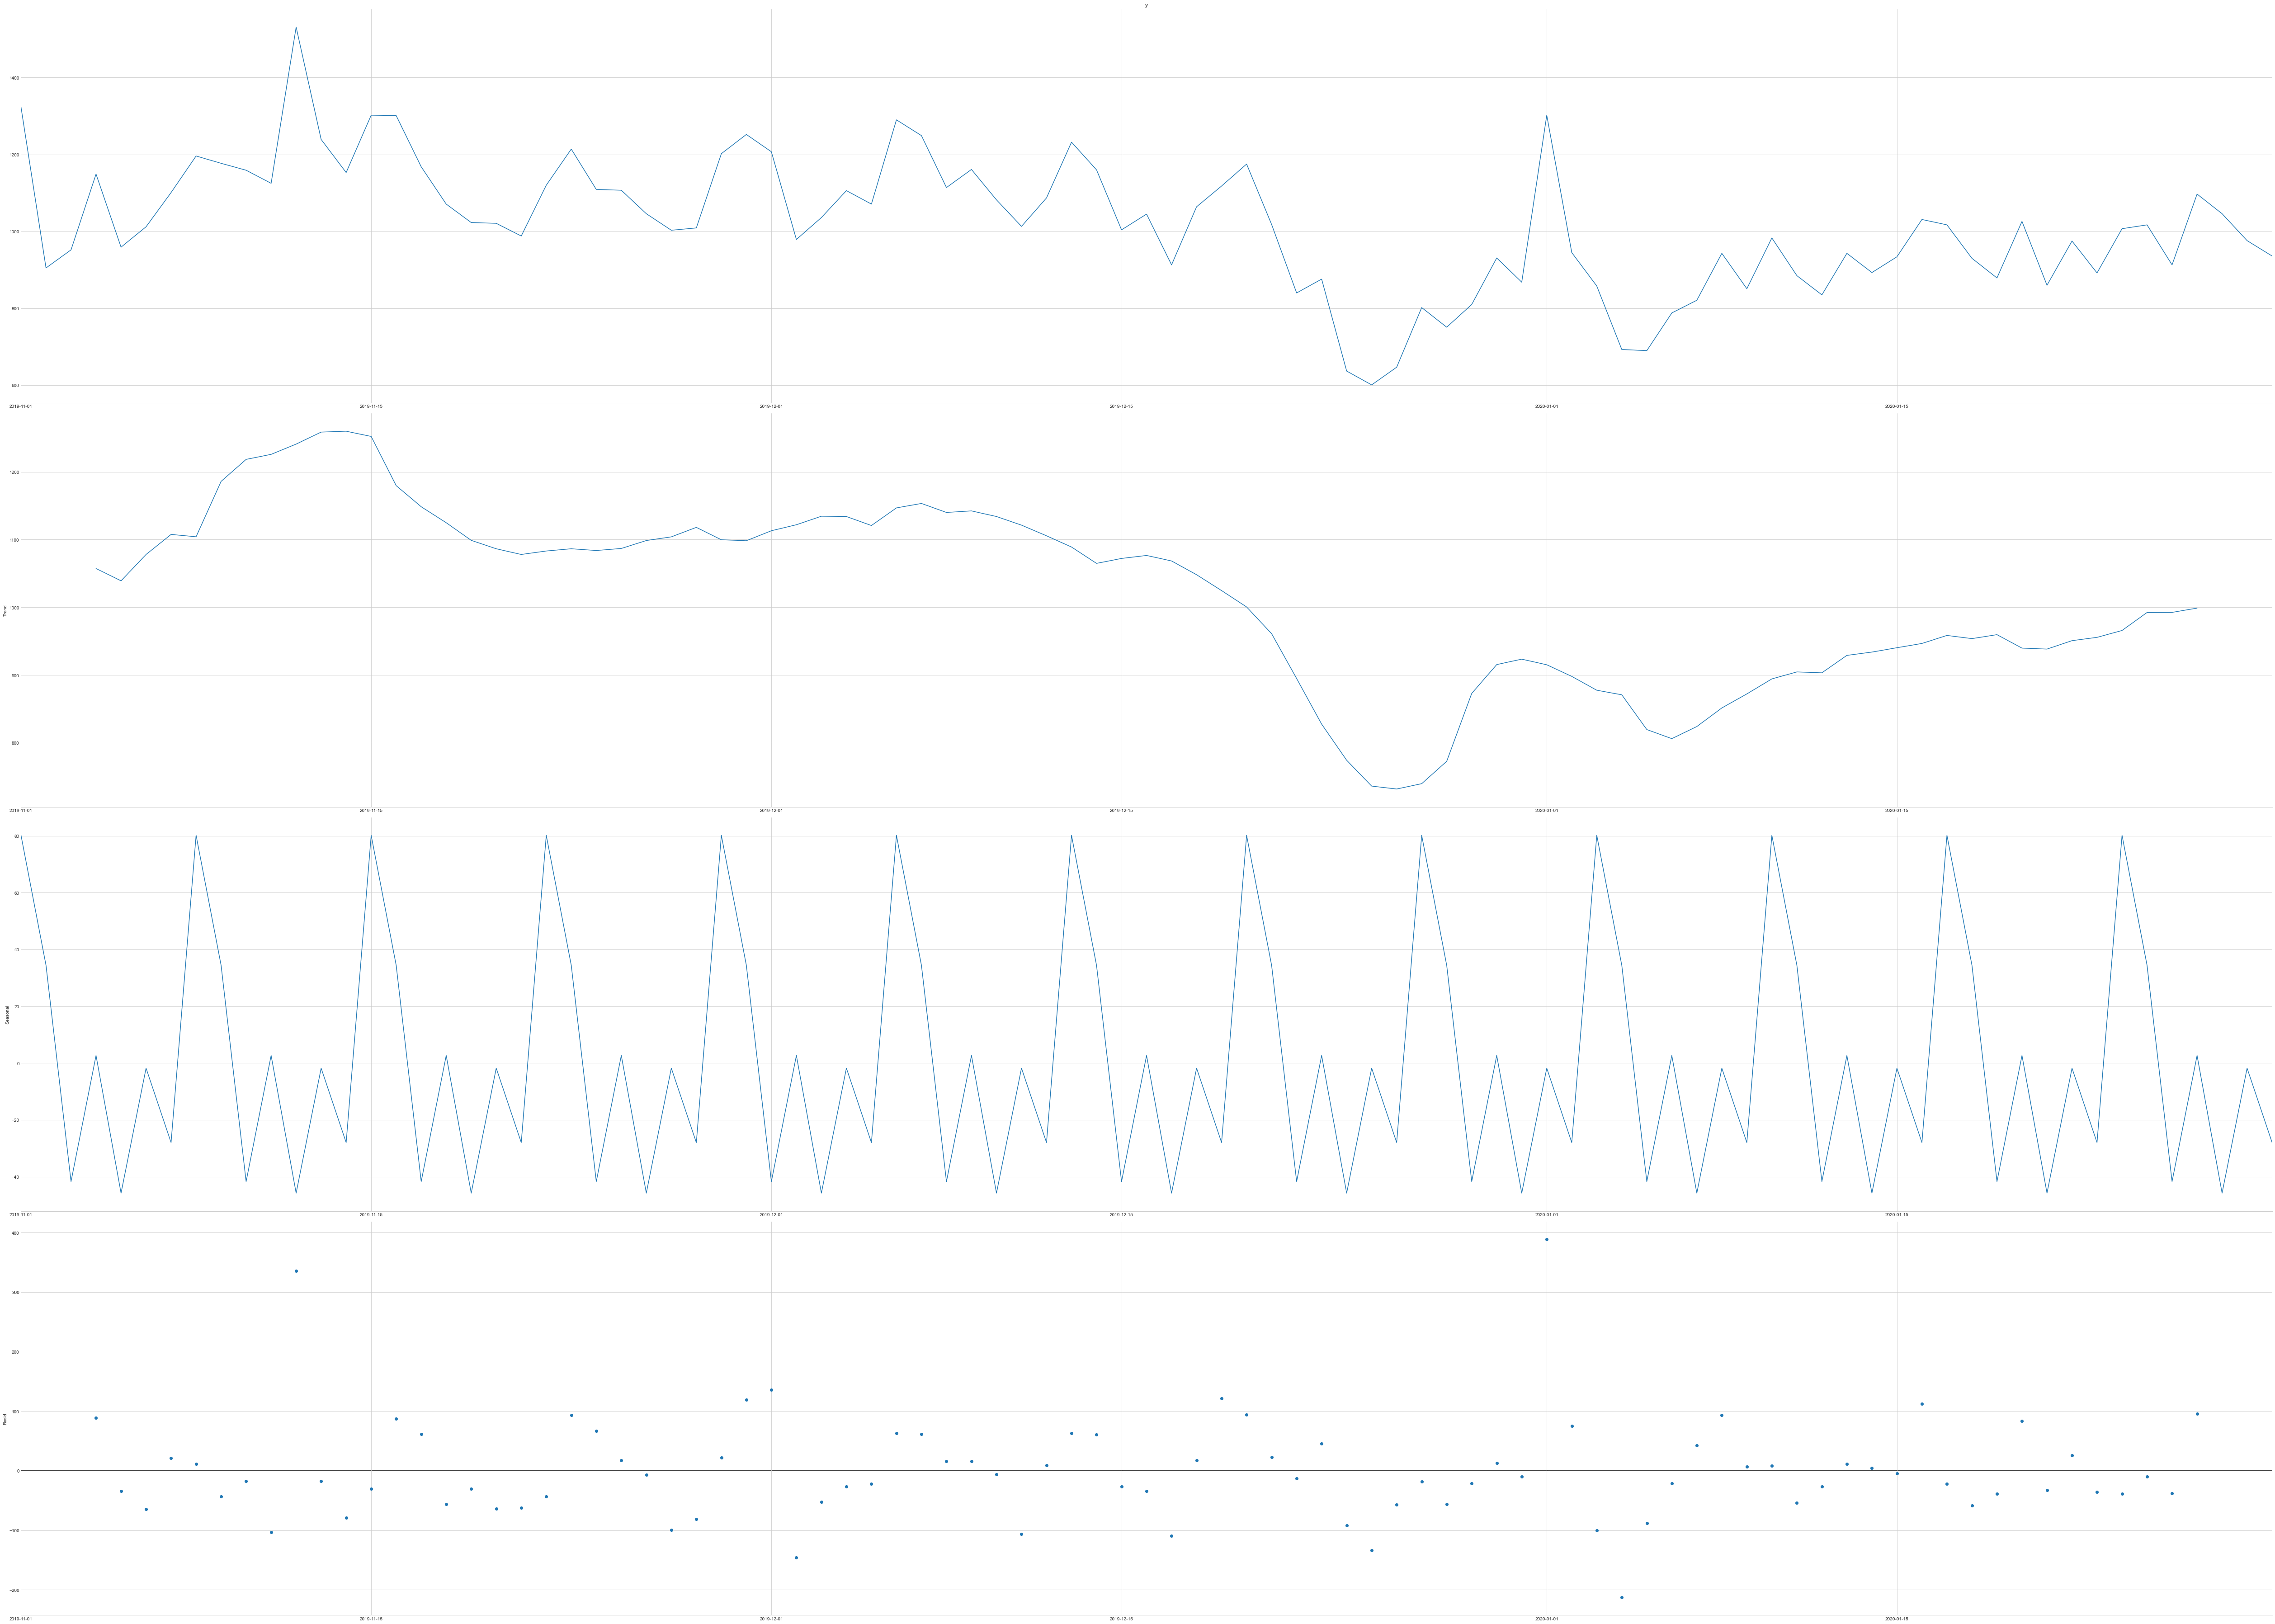

In [8]:
decompose_time_series(tickets_daily['y'])

We can decompose the time series for our most important KPI in a similar manner:

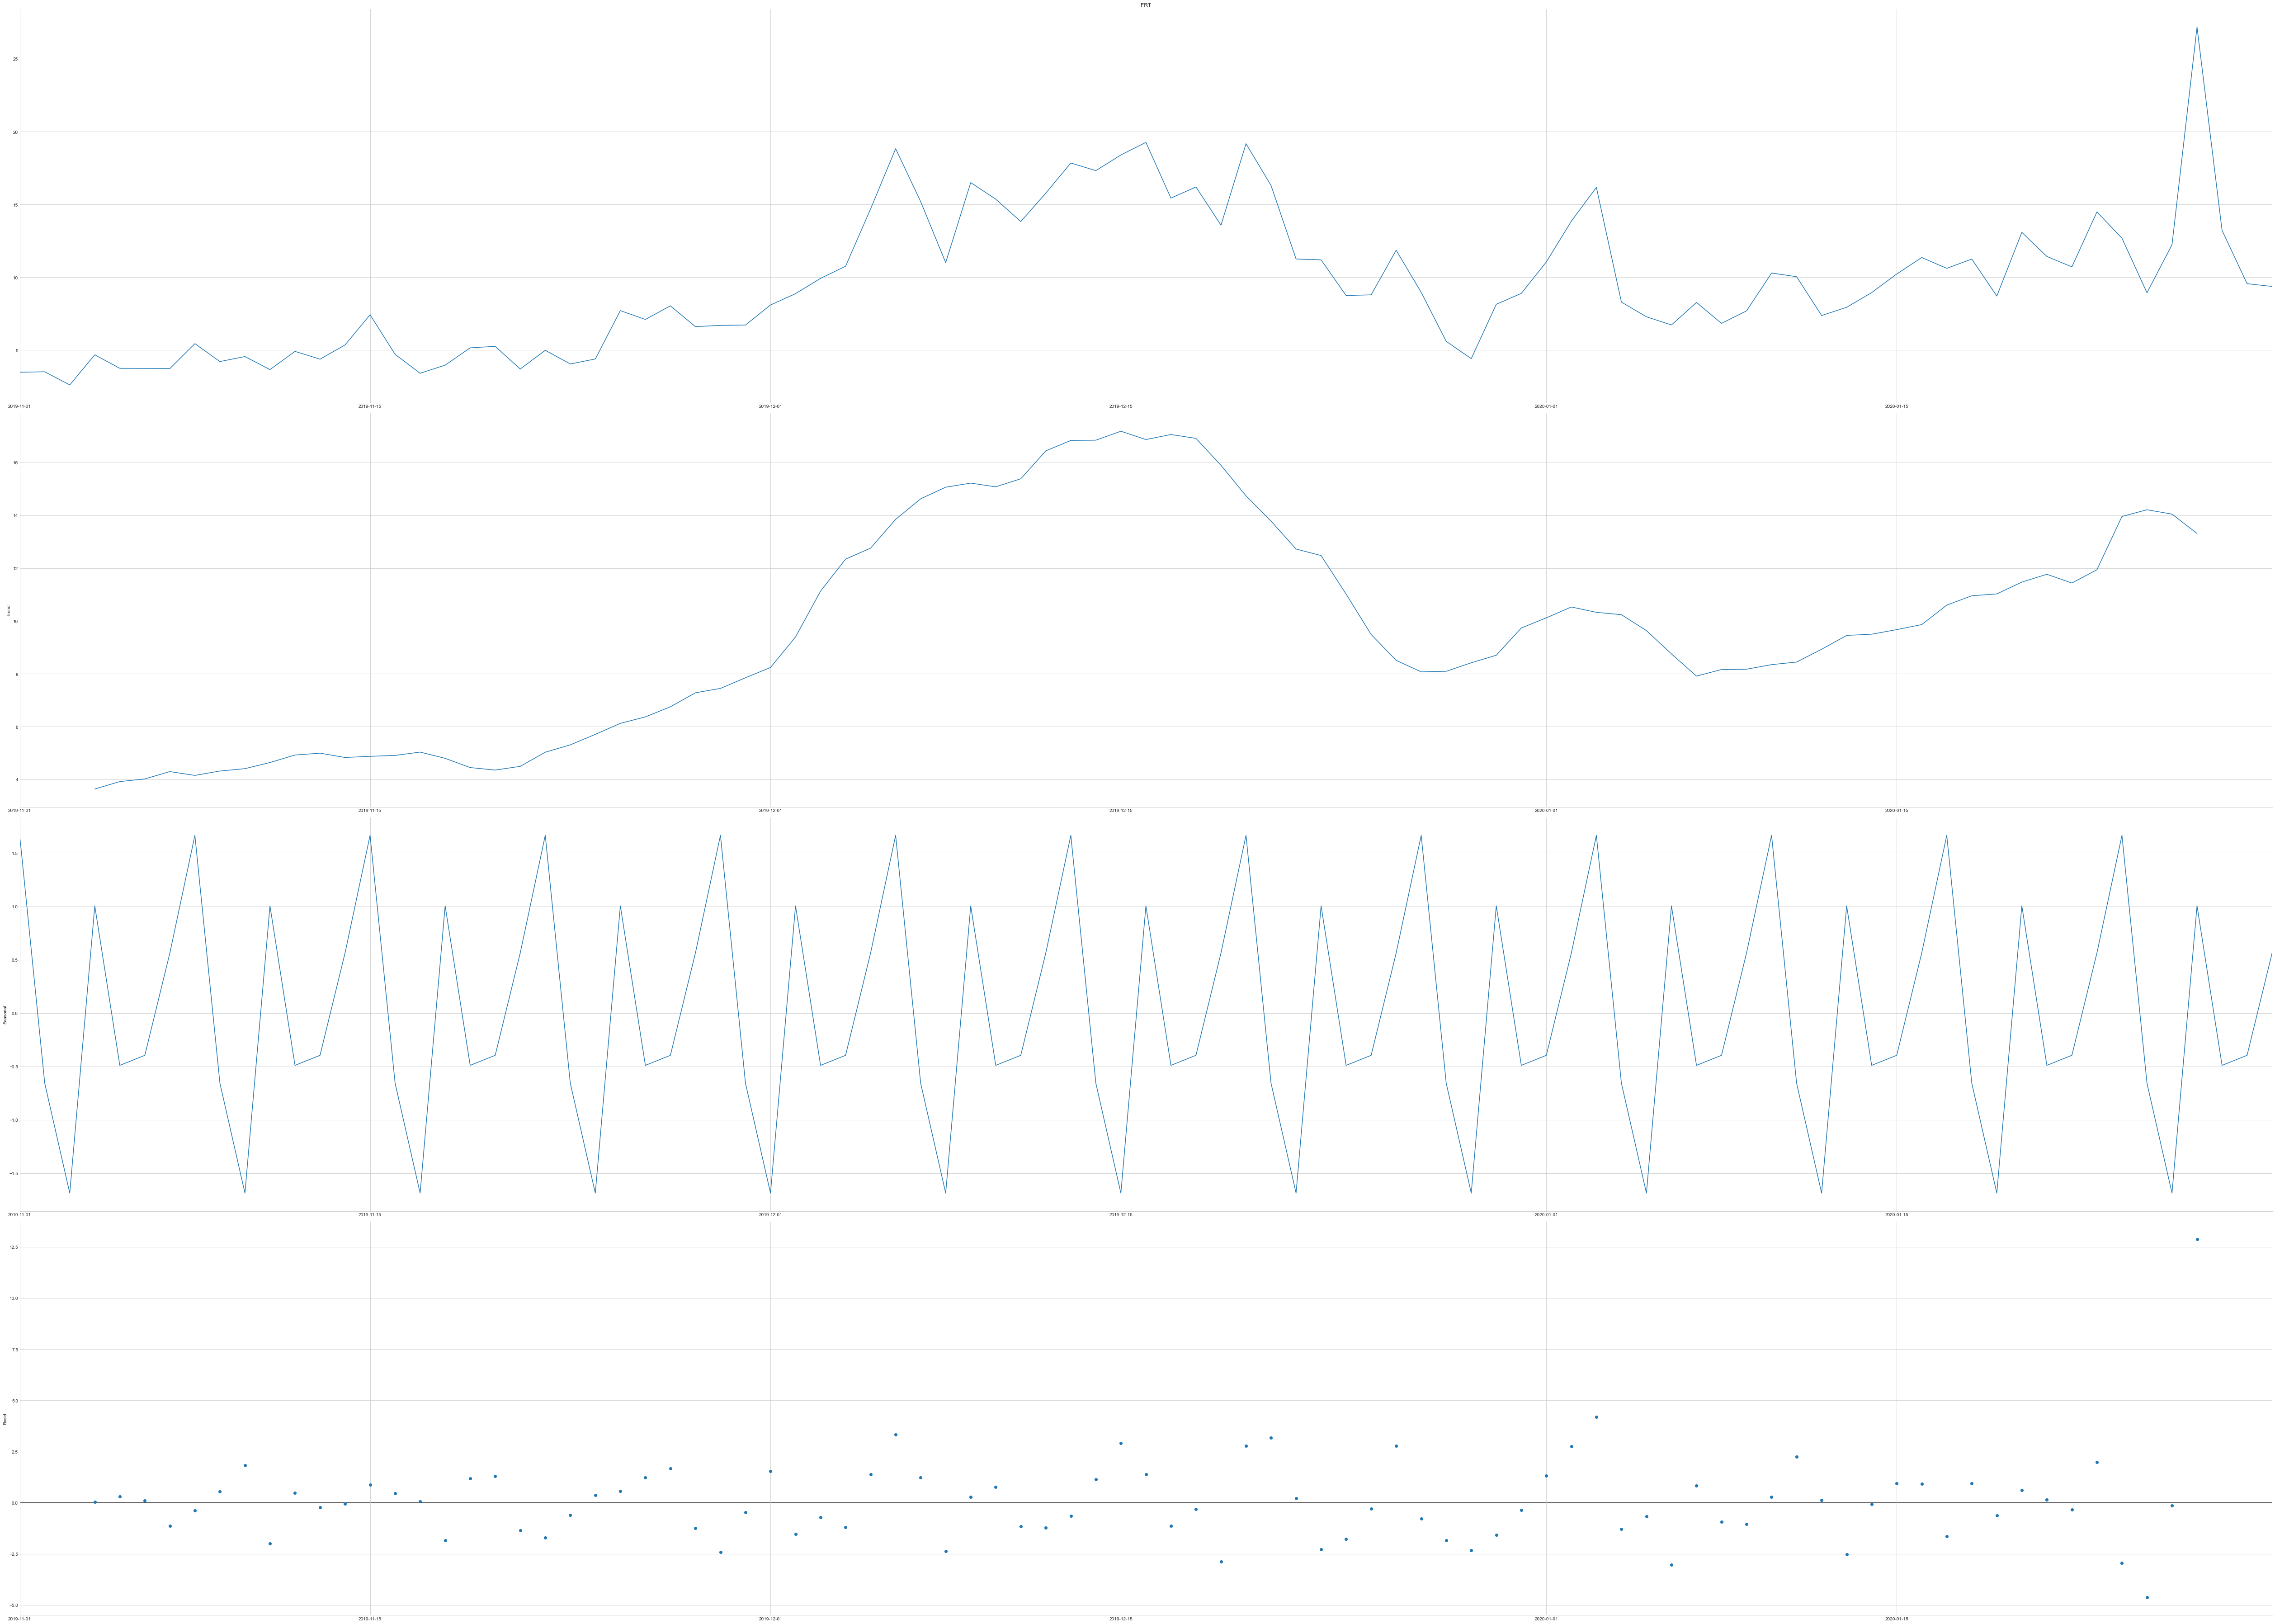

In [9]:
decompose_time_series(FRT_daily['FRT'])

Now, I can move on to the more technical details of inspecting the data, so the following section can be skipped by non-technical readers.

#### Robust vs non-robust weighting:

*This is a more technical section as well which can be skipped by non-technical readers.*

I can try to obtain a more accurate decomposition by experimenting with various methods. For instance, I can use the LOESS (Locally estimated scatterplot smoothing) approach with either robust or non-robust weighting. This will enable me to see whether there is significant difference between using either of the two.

It's not immediately clear whether the standard decomposition function used by statsmodels.seasonal package is not sufficient here, but we will still try this.

Setting the option to *robust* allows us to use a data-dependent weighting function that re-weights data when estimating the LOESS and the same principle is applied to LOWESS. Using robust estimation allows the model to tolerate larger errors that are visible on the bottommost plot.

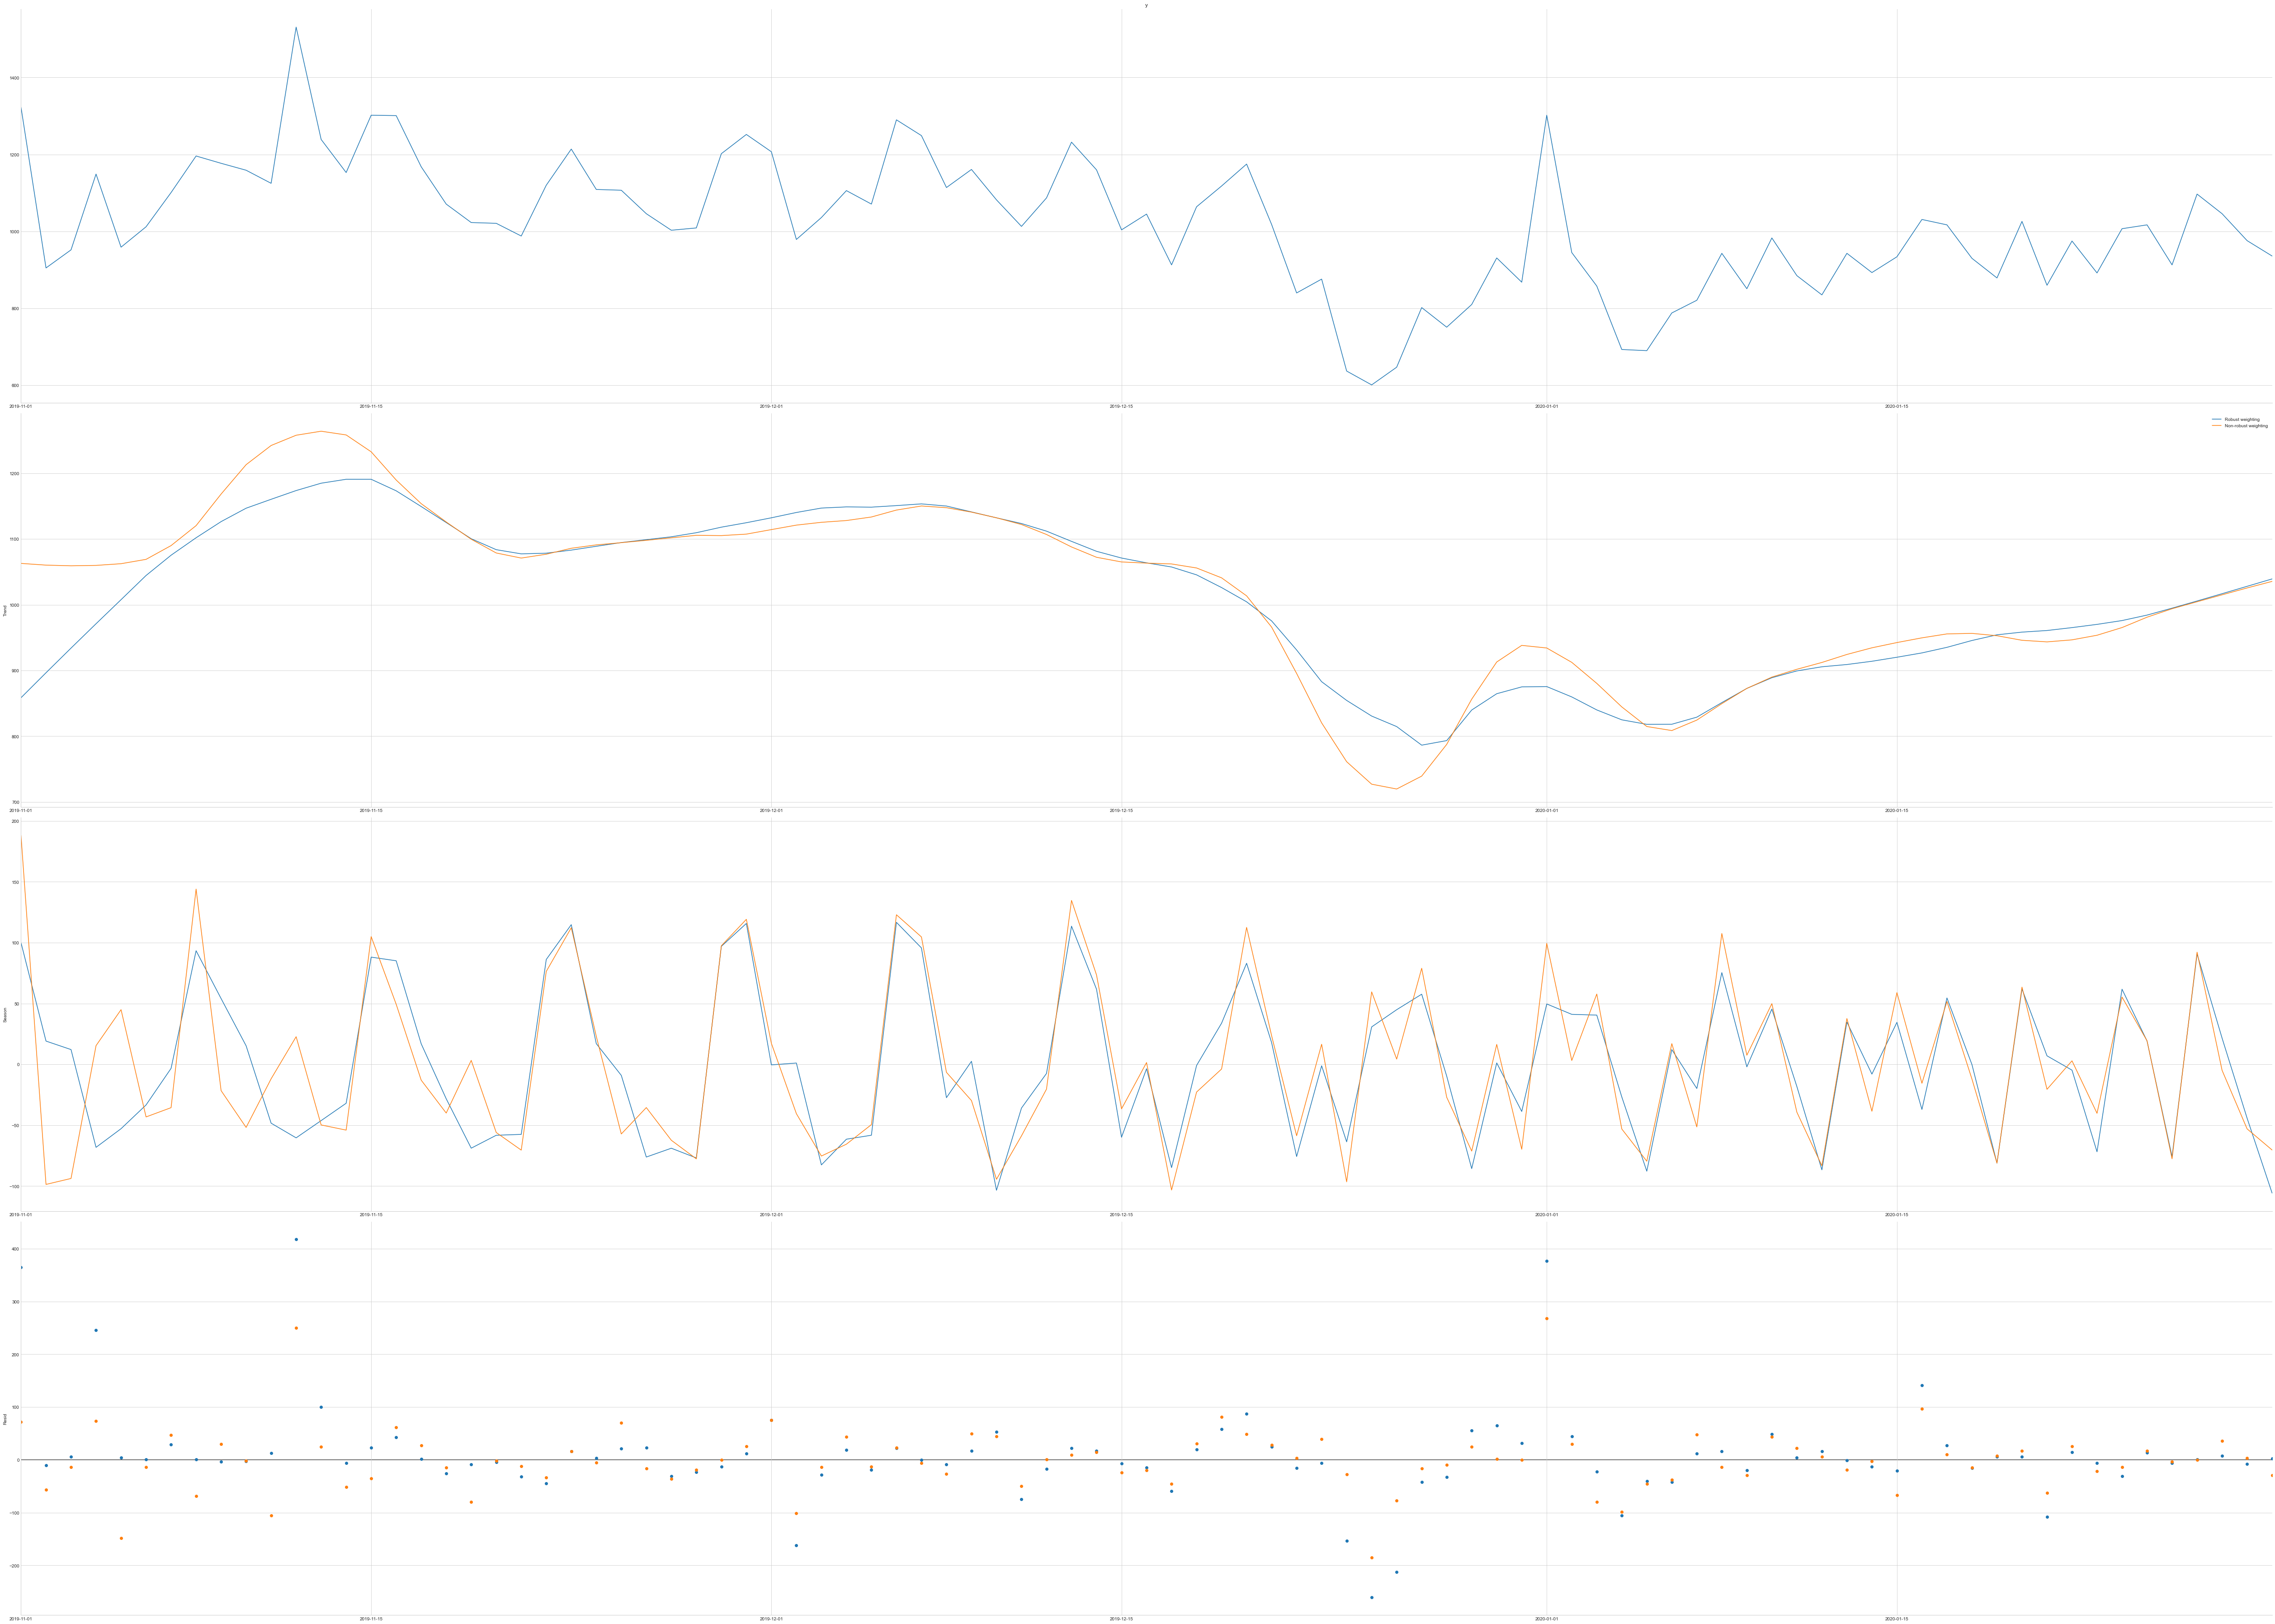

In [10]:
from statsmodels.tsa.seasonal import STL

def add_stl_plot(fig, res, legend):
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)

res_robust = STL(tickets_daily['y'], period=7, robust=True).fit()
fig = res_robust.plot()
res_non_robust = STL(tickets_daily['y'], period=7, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust weighting','Non-robust weighting'])

As we can see, the difference is minor and is most pronounced during the extreme spike on Nov 12 and Jan 1. The non-robust option places equal weights on all observations and so produces smaller errors, on average. The weights usually vary between 0 and 1.

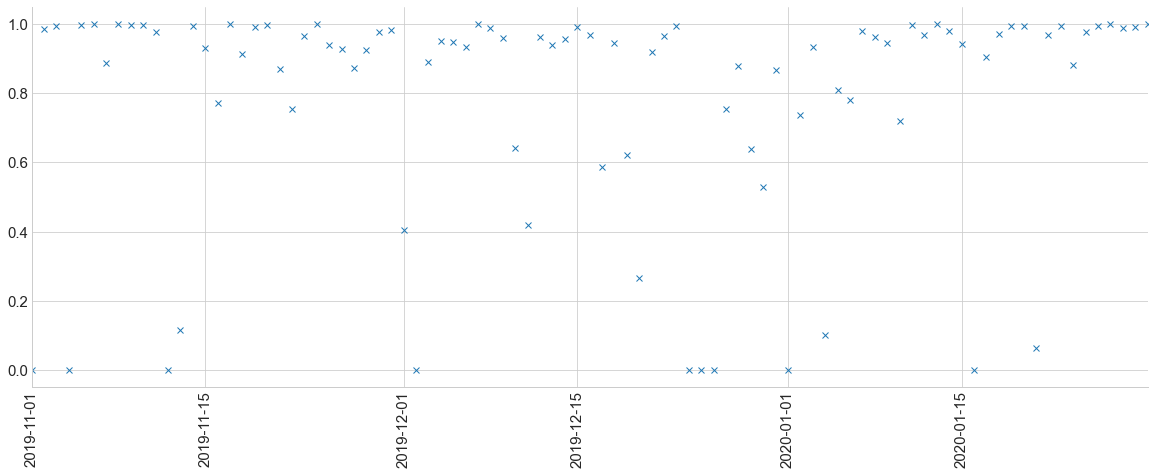

In [11]:
fig = plt.figure(figsize=(20,7))
lines = plt.plot(res_robust.weights, marker='x', linestyle='none')
ax = plt.gca()
xlim = ax.set_xlim(tickets_daily.index[0], tickets_daily.index[-1])
plt.xticks(fontsize = 15, rotation=degrees)
plt.yticks(fontsize = 15)
plt.show()

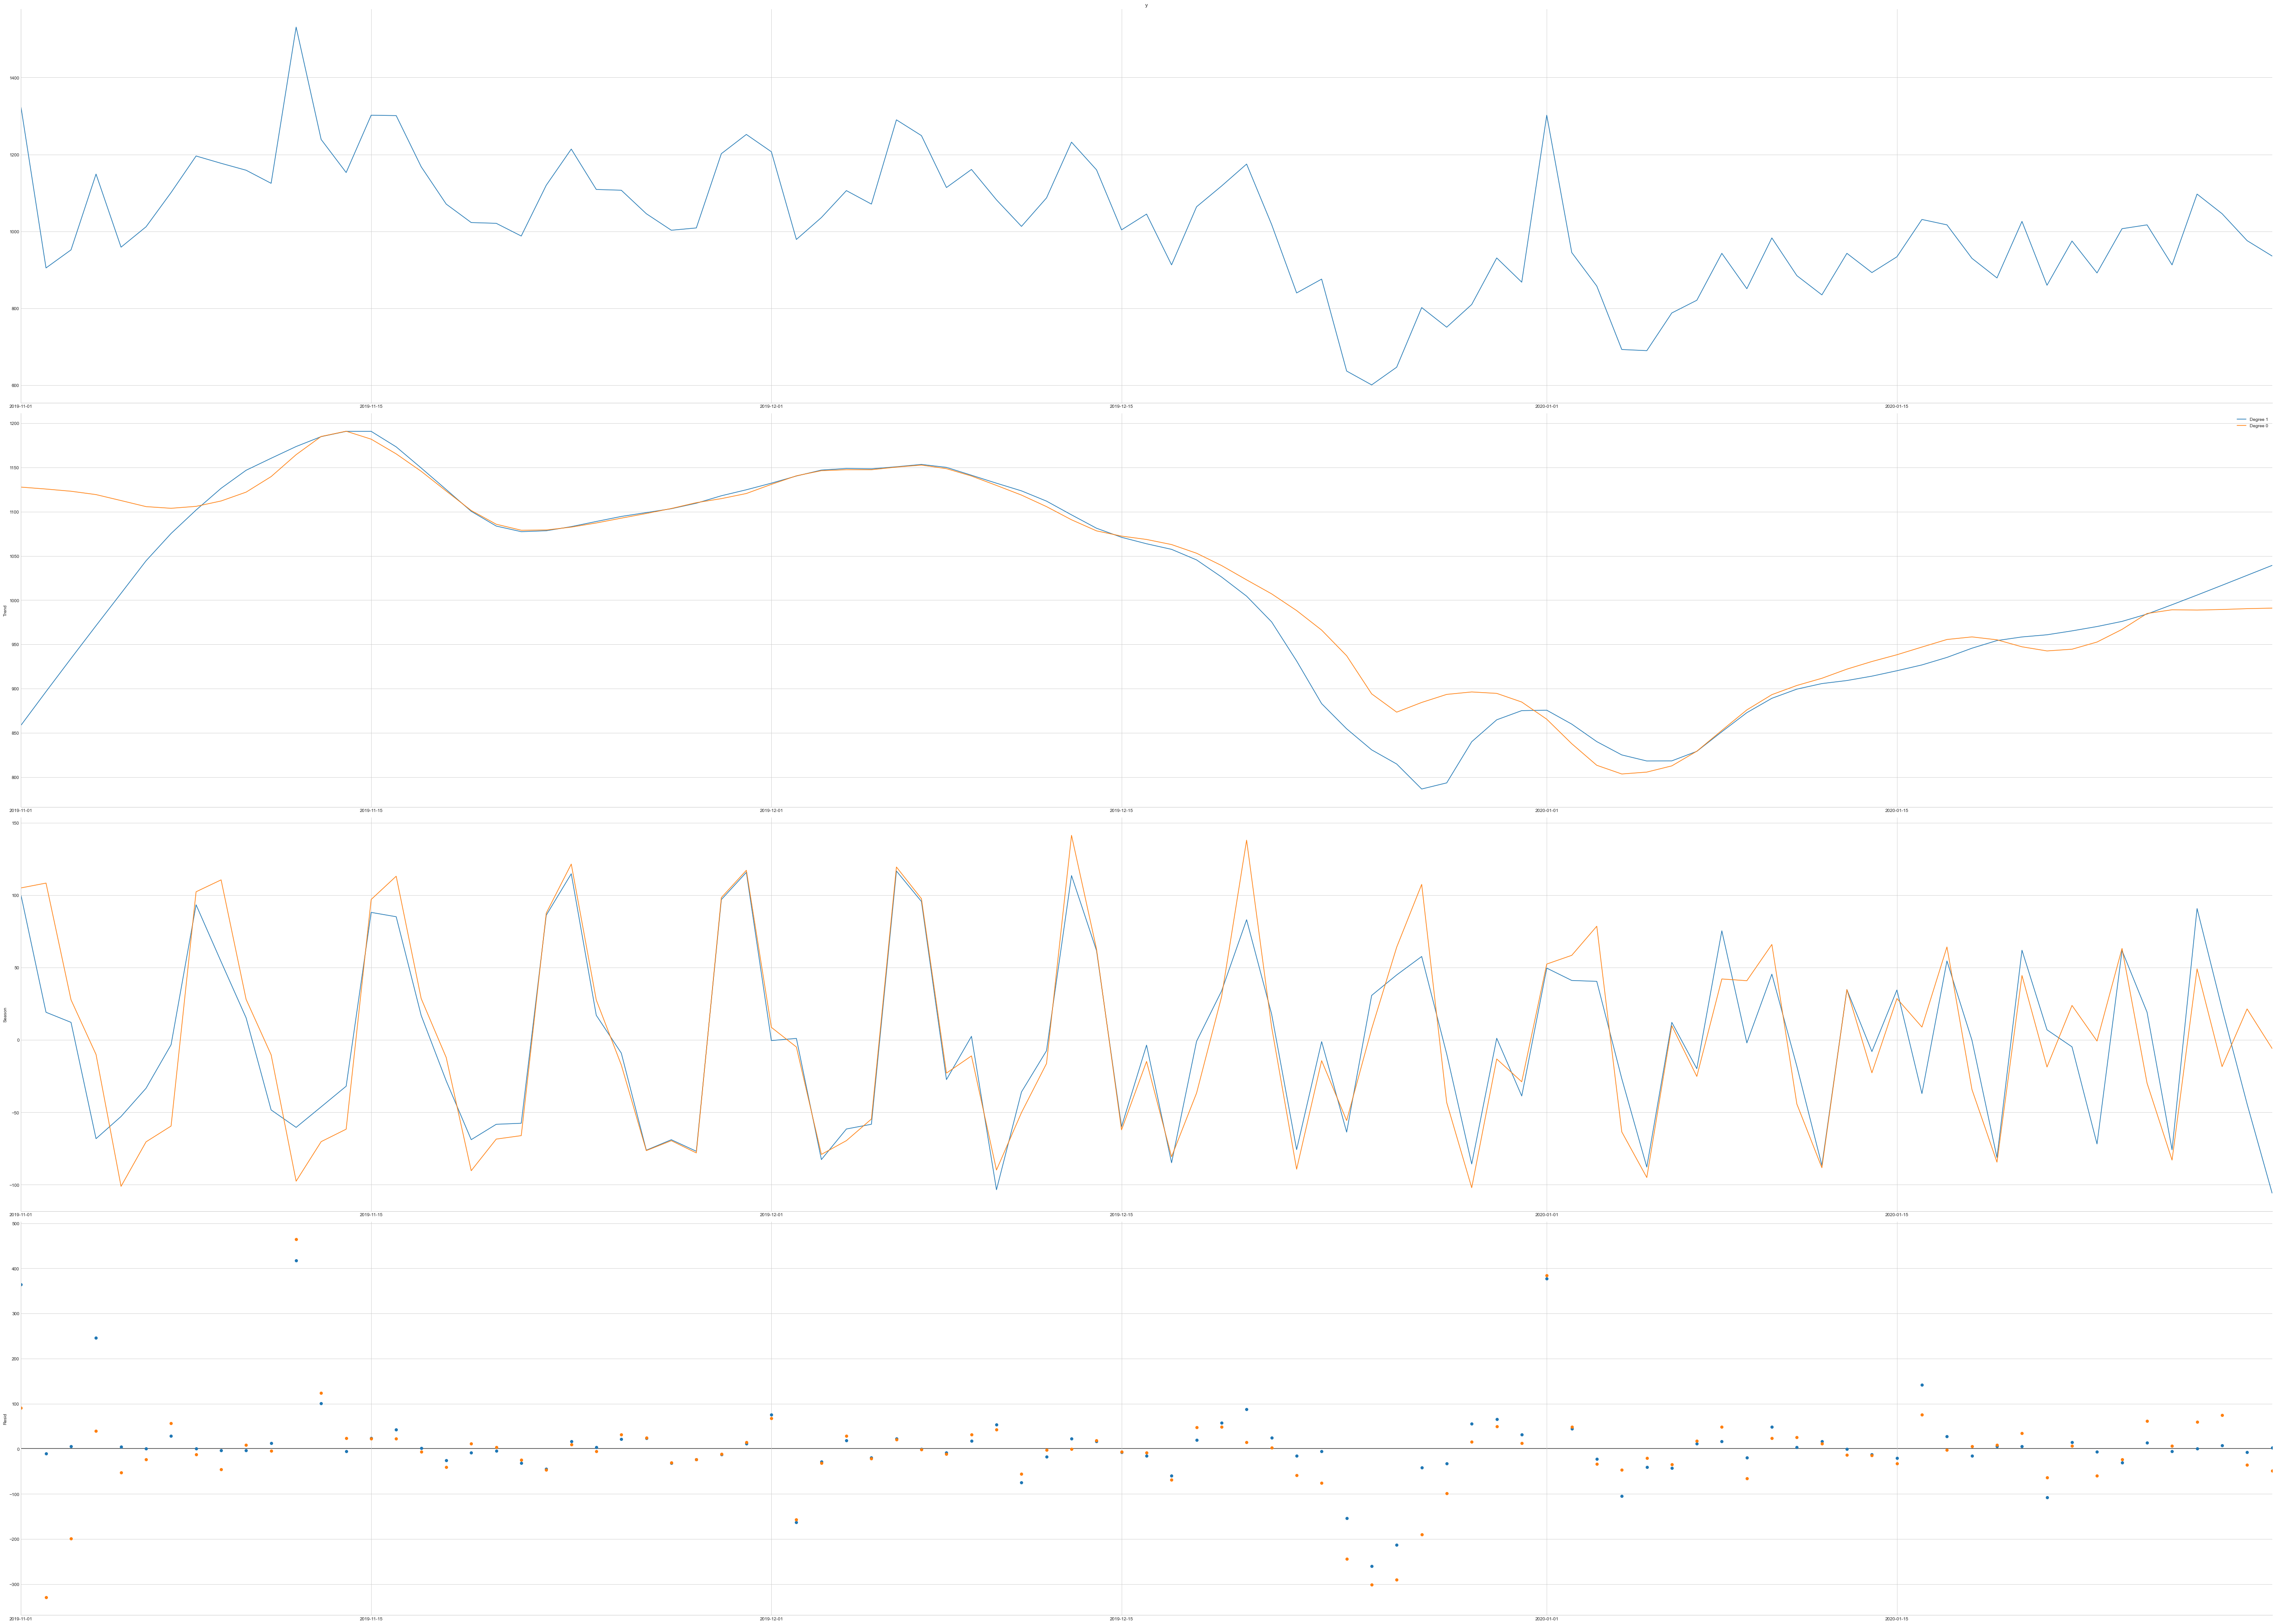

In [12]:
res_deg_0 = STL(tickets_daily['y'], period=7, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True).fit()
fig = res_robust.plot()
add_stl_plot(fig, res_deg_0, ['Degree 1','Degree 0'])

### Checking stationarity:

In order to check whether the series can be used for modelling without further transformations we need to statistically verify whether it is indeed stationary as it appeared in the plot above.

We can test whether a time series is stationary, i.e. whether the statistical properties of the times series, including mean, variance, and autocorrelation, are constant over time, by running it through the Augmented-Dickey-Fuller test. The Augmented Dickey-Fuller Test tests the null hypothesis that a unit root is present in a time series (i.e. if a unit root is in the time series, then it isn’t stationary). I set  the level of significance, i.e. the probability of rejecting the null hypothesis when it is, in fact, true to 5%. Hence, to successfully determine that a time series is stationary, the test must return a p-value of less than 0.05. To do so, I will define a custom function that spits out the results of the ADF test.

In [13]:
#Defining a function that yields the ADF test results
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

I am running my series through the ADF test:

In [14]:
pp.pprint('Augmented Dickey-Fuller Test: Daily Tickets Time series')
augmented_dickey_fuller_statistics(tickets_daily['y'].dropna())

'Augmented Dickey-Fuller Test: Daily Tickets Time series'
ADF Statistic: -4.408799
p-value: 0.000286
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584


We can see that since the p-value of the test is less than 0.05, the null hypothesis can be rejected and the time series is indeed stationary. Hence, no further manipulations are necessary and we can proceed to selecting the model. This is perhaps not too surprising if the market which received these Customer Support complaints is fairly mature with the relatively stable amount of rides, but one would have to consult with the relevant domain expert, e.g. an operations specialist and a CS Team Lead before stating this definitively. 

## Choosing the forecasting model:

### ARIMA:

ARIMA is also a natural candidate for forecasting in this context.

### Triple Exponential Smoothing (Holt-Winters):

In [15]:
import plotly.express as px

Holt-Winters is a natural candidate for forecasting my time series because the data is, as we saw earlier, strongly seasonal, exhibits stationarity and, as a result, also seemingly not stochastic.